In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import pyarrow as pa
from pyarrow import parquet
import seaborn as sns
import torch

import matplotlib.pyplot as plt

In [2]:
def get_rel_ebs(table_name):
    if table_name == "ethylene_methane":
        rel_ebs = [1.0] * 8 + [0.01] * 8
        rel_ebs[1] = 0.01
        parquet_file_or_folder = "../datasets/gas_sensor/ethylene_methane.parquet"
    elif table_name == "ethylene_CO":
        rel_ebs = [1.0] * 8 + [0.01] * 8
        parquet_file_or_folder = "../datasets/gas_sensor/ethylene_CO.parquet"
    elif table_name == "heavy_drinking":
        rel_ebs = [10.0] * 3
        parquet_file_or_folder = (
            "../datasets/heavy_drinking/all_accelerometer_data_pids_13.parquet"
        )
    else:
        raise ValueError(f"Unsupported Table Name: {table_name}")
    rel_ebs = [rel_eb * 1e-2 for rel_eb in rel_ebs]
    return rel_ebs, parquet_file_or_folder


def load_data(table_name):
    rel_ebs, path = get_rel_ebs(table_name)
    arrow_table = parquet.read_table(path)
    
    return arrow_table, rel_ebs

def plot_time_and_freq_domain(t, signal, freq, PSD):
    # Plot in time domain
    fig, axs = plt.subplots(2,1)
    plt.sca(axs[0])
    plt.plot(t, signal)
    plt.xlabel("time (s)")
    plt.ylabel("y")
    plt.title("time domain")


    # Plot in frequency domain
    plt.sca(axs[1])
    plt.plot(freq, PSD)
    plt.title("frequency domain")
    plt.xlabel("freq")
    plt.ylabel("PSD")

    plt.show() 
    
def fft_signal(signal, dt=0.01):
    """ signal is a 1-D signal """
    n = len(signal)
    t = np.arange(n) * dt

    # Perform fft
    fhat = fft(signal)
    PSD = fhat * np.conj(fhat) / n
    freq = np.arange(n) / (dt * n)

    plot_time_and_freq_domain(t, signal, freq, PSD)
    return fhat, PSD

def filter_signal(fhat, PSD, psd_threshold=1000, freq_threshold=0.8, dt=0.01):
    indices = PSD > 1000
    index_threshold = int(freq_threshold * len(indices))
    indices[index_threshold:] =0
    fhat = fhat * indices
    ffilt = ifft(fhat)

    # Plot
    n = len(fhat)
    t = np.arange(n) * dt
    freq = np.arange(n) / (dt * n)
    PSD = fhat * np.conj(fhat) / n
    plot_time_and_freq_domain(t, ffilt, freq, PSD)
    return ffilt.real

In [3]:
table, rel_ebs = load_data("ethylene_CO")
df = table.to_pandas()
print(df.describe())

           sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  4.208262e+06  4.208262e+06  4.208262e+06  4.208262e+06  4.208262e+06   
mean   2.065616e+03  5.062184e+02  4.372539e+03  4.799244e+03  1.894957e+03   
std    7.897863e+02  1.474847e+03  1.604716e+03  1.729003e+03  4.390423e+02   
min   -5.262000e+01 -3.649000e+01 -4.504000e+01 -8.940000e+00 -1.219000e+01   
25%    1.323470e+03  9.120000e+00  2.986960e+03  3.282310e+03  1.503460e+03   
50%    1.789090e+03  3.889000e+01  4.494330e+03  4.946720e+03  1.984550e+03   
75%    2.869440e+03  1.589000e+02  5.658290e+03  6.178210e+03  2.262740e+03   
max    3.553640e+03  2.811651e+04  8.641340e+03  9.221020e+03  2.904040e+03   

           sensor_6      sensor_7      sensor_8      sensor_9     sensor_10  \
count  4.208262e+06  4.208262e+06  4.208262e+06  4.208262e+06  4.208262e+06   
mean   2.214691e+03  5.086638e+03  5.385426e+03  1.186241e+03  1.219252e+03   
std    4.350525e+02  1.964045e+03  2.068489e+03  4.

In [80]:
def preprocess(df, reduce_factor=10, process_mode="average"):
    length = len(df) // reduce_factor
    width = len(df.columns)
    reduced_ndarray = np.empty((length, width), dtype=np.float32)
    if process_mode == "fourier":
        pass
    elif process_mode == "average":
        for i in range(length):
            start_idx = i * reduce_factor
            end_idx = (i + 1) * reduce_factor
            reduced_ndarray[i] = df.iloc[start_idx:end_idx].mean(axis=0).values
    else:
        raise NotImplementedError
    return reduced_ndarray

reduced_ndarray = preprocess(df,reduce_factor=100)

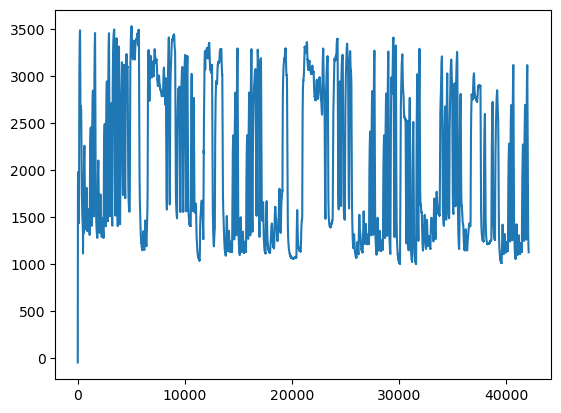

In [81]:
plt.plot(reduced_ndarray[:100000,0])

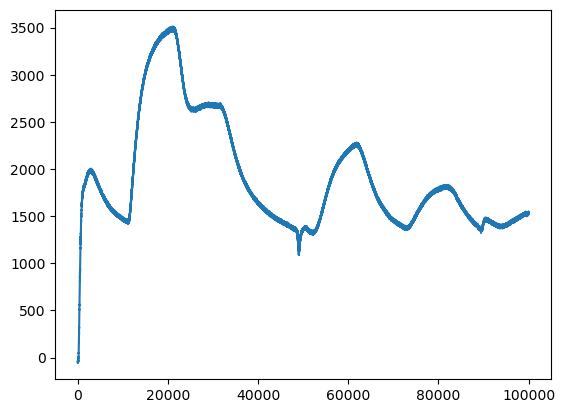

In [34]:
plt.plot(df.iloc[:100000,0])

In [61]:
def ts_distortion(ts1: np.array, ts2: np.array, mode="rmse"):
    """ts1 is the original time series, ts2 is the reconstructed time series"""
    mse = np.mean((ts1 - ts2) ** 2)
    if mode == "mse":  # Mean Squared Error
        return mse
    elif mode == "rmse":  # Root Mean Squared Error
        return np.sqrt(mse)
    elif mode == "mae":  # Mean Absolute Error
        return np.mean(np.abs(ts1 - ts2))
    elif mode == "snr":  # Signal to Noise Ratio
        return np.mean(ts1**2) / mse
    elif mode == "psnr":  # Peak Signal to Noise Ratio
        return np.max(ts1) ** 2 / mse
    else:
        raise ValueError(f"Unknown mode: {mode}")

In [83]:
print(reduced_ndarray.shape)
print(df.shape)
for col in range(15):
    ts1 = df.iloc[:4208200, col].values
    ts2 = reduced_ndarray[:, col].repeat(100)
    print(ts_distortion(ts1, ts2))

(42082, 16)
(4208262, 16)
8.572336
69.832726
15.80328
16.480513
9.535657
9.943255
19.18257
20.706726
66.829994
57.635494
18.467148
16.739412
25.086668
21.763596
20.19192


### Fourier transform with FFT

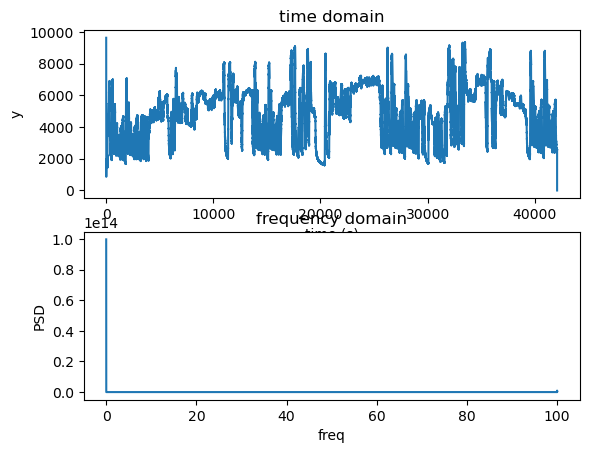

In [52]:
fhat, PSD = fft_signal(df["sensor_11"])

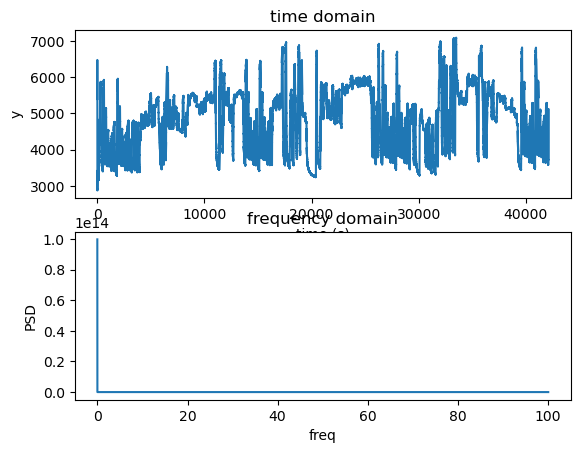

In [53]:
filtered_signal = filter_signal(fhat, PSD)

In [54]:
filtered_signal[:10000]

array([5397.98263868, 5502.66811998, 5621.05313312, ..., 3177.40092127,
       3177.60420932, 3174.80387823])

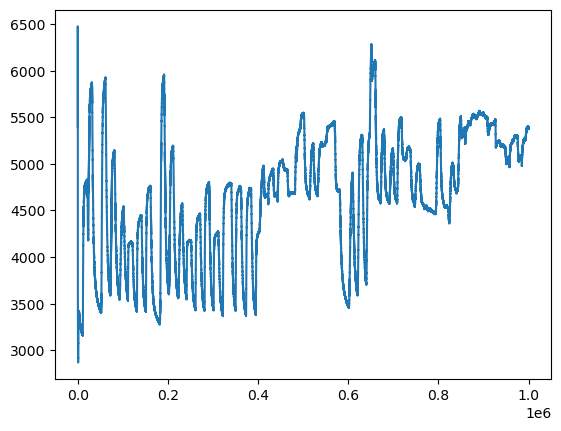

In [55]:
plt.plot(filtered_signal[:1000000])
plt.show()

In [56]:
ifft(fft(df["sensor_2"]))

array([-1.95000005e+00-1.25055521e-12j, -5.53000021e+00-7.35655270e-13j,
       -1.60900002e+01-1.21067024e-12j, ...,
        1.11080002e+02-6.54215831e-13j,  9.84499969e+01+1.35787323e-12j,
        1.42108564e-12-2.27372615e-13j])

<Axes: ylabel='sensor_11'>

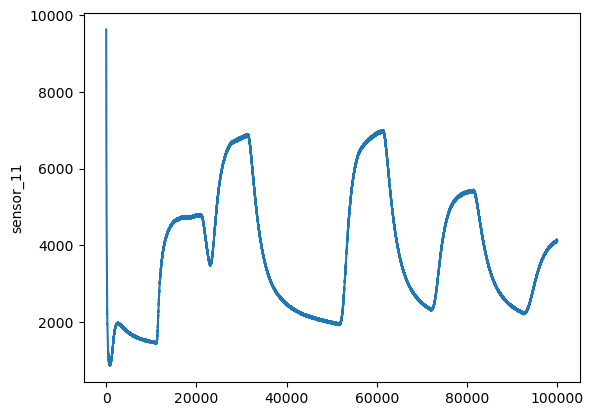

In [19]:
sns.lineplot(data=df["sensor_11"][:100000])

<Axes: ylabel='sensor_12'>

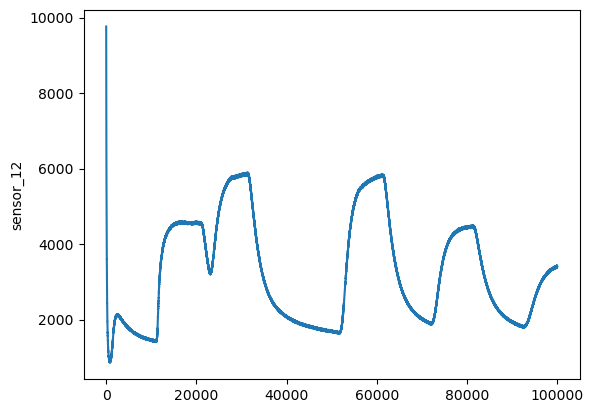

In [20]:
sns.lineplot(data=df["sensor_12"][:100000])

<Axes: ylabel='Frequency'>

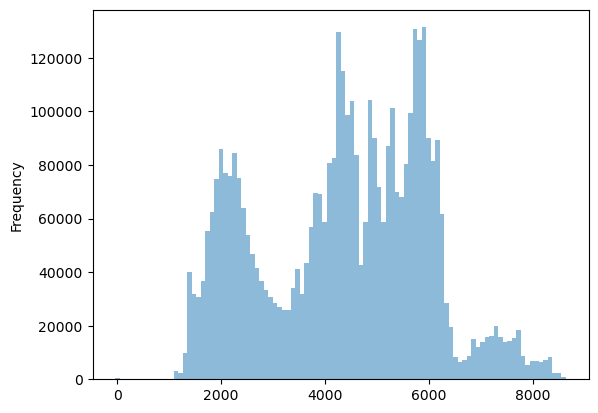

In [13]:
df["sensor_3"].plot.hist(bins=100, alpha=0.5)

In [14]:
corr = df.corr()

<Axes: >

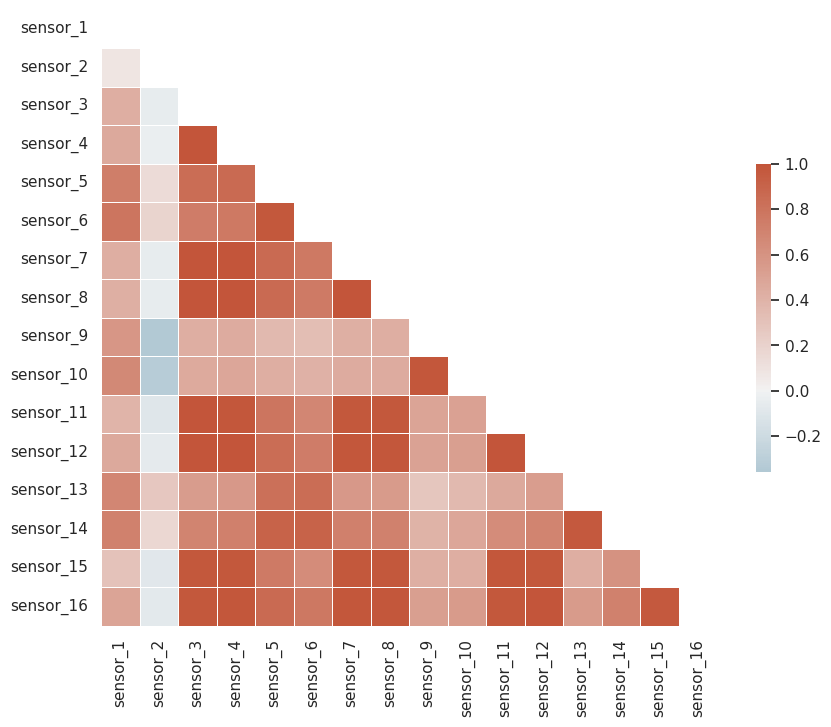

In [39]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
quantized_codes = torch.load(f"../outputs/ethylene_CO_partition_exp/quantized_aux/0/2.pt")


In [60]:
code_series = pd.Series(quantized_codes.numpy())

<Axes: ylabel='Frequency'>

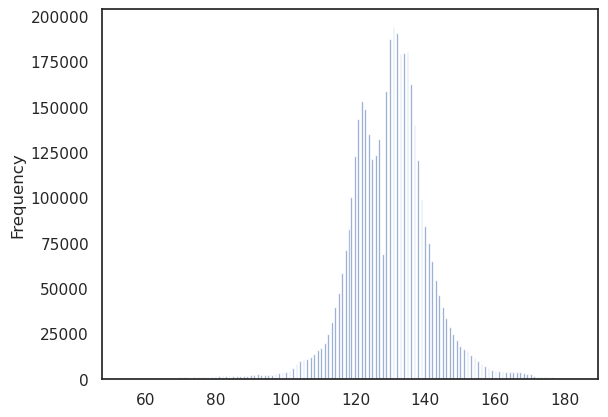

In [61]:
code_series.plot.hist(bins=256, alpha=0.8)